In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

In [2]:
import kagglehub
import os
import shutil

# Download latest version
# path = kagglehub.dataset_download("antobenedetti/animals")
path = r'C:\Users\ASUS\.cache\kagglehub\datasets\antobenedetti\animals\versions\5'
print("Path to dataset files:", path)

destination_path = '/content/animals_dataset'

os.makedirs(destination_path, exist_ok=True)

if os.path.isdir(path):
    if os.path.exists(destination_path) and os.listdir(destination_path):
        shutil.rmtree(destination_path)
        os.makedirs(destination_path)
    shutil.copytree(path, destination_path, dirs_exist_ok=True)
    print(f"Dataset copied to: {destination_path}")
elif os.path.isfile(path):
    shutil.copy(path, destination_path)
    print(f"Dataset file copied to: {destination_path}")
else:
    print(f"Warning: {path} is neither a directory nor a file.")

path = destination_path
print("New working path for the dataset:", path)


C:\Users\ASUS\tfenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\ASUS\.cache\kagglehub\datasets\antobenedetti\animals\versions\5
Dataset copied to: /content/animals_dataset
New working path for the dataset: /content/animals_dataset


In [3]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

path_imgs = list(glob.glob(os.path.join(path, '**', '*.jpg'), recursive=True))
# path_imgs = list(glob.glob(os.path.join(path, '**', '*.jpg', '*.png', '*jpeg'), recursive=True))

labels = [os.path.basename(os.path.dirname(p)) for p in path_imgs]
data = pd.DataFrame({'File_Path': path_imgs, 'Labels': labels})
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Hanya mengambil gambar Bread, Soup, dan meat saja
# Mengurangi jumlah dataset agar kompleksitas lebih terjaga
# target = 10000
data = data[~data['Labels'].isin(
    ['inf'])]
print(data['Labels'].value_counts())
print(f"Total gambar after filter: {len(data)}")
print(f"Total kelas unik after filter: {data.Labels.nunique()}")

Labels
cat         3037
elephant    2992
lion        2936
dog         2927
horse       2754
Name: count, dtype: int64
Total gambar after filter: 14646
Total kelas unik after filter: 5


5


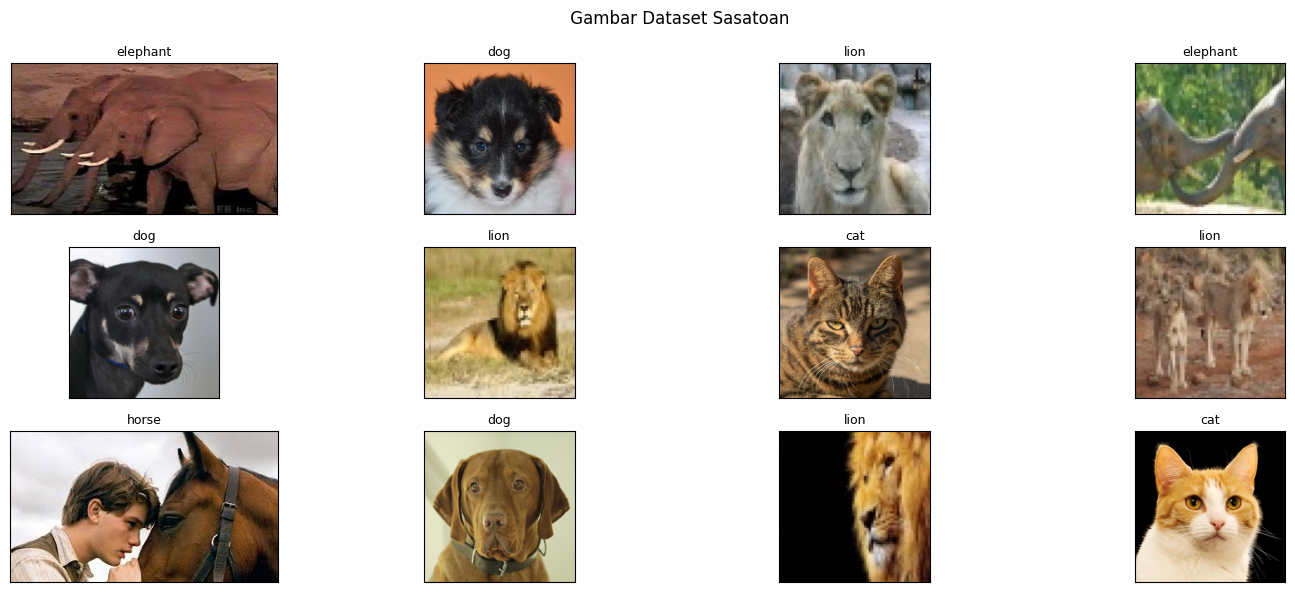

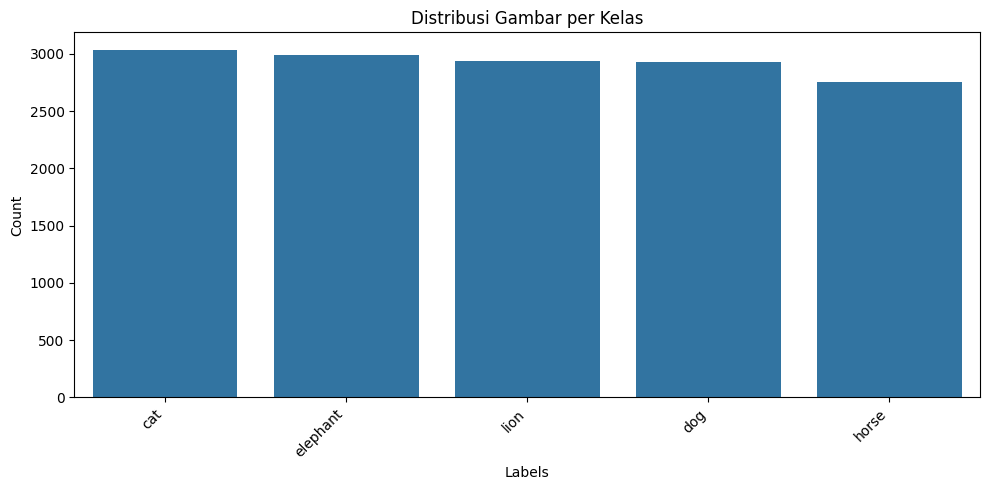

In [4]:
# Ambil daftar label kelas untuk referensi
CLASS_LABELS = sorted(data.Labels.unique())
NUM_CLASSES = len(CLASS_LABELS)

print(NUM_CLASSES)
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 6),
                         subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    if i < len(data):
        img = plt.imread(data.File_Path.iloc[i])
        ax.imshow(img)
        ax.set_title(data.Labels.iloc[i], fontsize=9)
    else:
        fig.delaxes(ax)
plt.suptitle(' Gambar Dataset Sasatoan')
plt.tight_layout()
plt.show()

# Plot Distribusi Kelas
plt.figure(figsize=(10, 5))
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts.values)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribusi Gambar per Kelas')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [5]:
data.head()

,File_Path,Labels
0,/content/animals_dataset\animals\train\elephan...,elephant
1,/content/animals_dataset\animals\val\dog\dog25...,dog
2,/content/animals_dataset\animals\val\lion\lion...,lion
3,/content/animals_dataset\animals\train\elephan...,elephant
4,/content/animals_dataset\animals\train\dog\dog...,dog


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14646 entries, 0 to 14650
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   File_Path  14646 non-null  object
 1   Labels     14646 non-null  object
dtypes: object(2)
memory usage: 343.3+ KB


In [7]:
from sklearn.model_selection import train_test_split
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Split Data
train_val_df, test_df = train_test_split(
    data, test_size=0.2, stratify=data.Labels, random_state=42
)

train_df, val_df = train_test_split(
    train_val_df, test_size=0.25, stratify=train_val_df.Labels, random_state=42
)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

Train: 8787 | Val: 2929 | Test: 2930


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input

# Augmentasi Data
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    brightness_range=[0.7, 1.3],
    shear_range=0.15,
    preprocessing_function=preprocess_input
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='File_Path',
    y_col='Labels',
    target_size=IMG_SIZE, # height, width
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

valid_gen = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='File_Path',
    y_col='Labels',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_gen = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='File_Path',
    y_col='Labels',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)
# val_test_datagen.info()

Found 8787 validated image filenames belonging to 5 classes.
Found 2929 validated image filenames belonging to 5 classes.
Found 2930 validated image filenames belonging to 5 classes.


In [9]:
from sklearn.utils.class_weight import compute_class_weight
# hitung jumlah tiap kelas
labels_numeric = train_gen.classes
labels_numeric2 = valid_gen.classes
counts = pd.Series(np.concatenate([labels_numeric, labels_numeric2])).value_counts().sort_index()

# Hitung Bobot dari setiap kelas
# Agar lebih adil dan menjaga keseimbangan model terhadap pemahaman data
# ambil label numeric dari generator

# id kelas (0..N-1)
class_ids = np.unique(labels_numeric)
# hitung bobot pakai label numeric
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=class_ids,
    y=labels_numeric
)

# dict sesuai format Keras
class_weight_dict = dict(zip(class_ids, class_weights))

# balik mapping: id -> nama kelas
idx_to_class = {v: k for k, v in train_gen.class_indices.items()}

print("\nClass Weight Distribusi Sasatoan!:")
for k, v in class_weight_dict.items():
    print(f"{idx_to_class[k]}: {v:.3f}")

# buat tabel
dist_df = pd.DataFrame({
    "Label": [idx_to_class[i] for i in counts.index],
    "Jumlah": counts.values
})

print("\nDistribusi Kelas (train_gen + valid_gen):")
print(dist_df)


Class Weight Distribusi Sasatoan!:
cat: 0.965
dog: 1.001
elephant: 0.979
horse: 1.064
lion: 0.997

Distribusi Kelas (train_gen + valid_gen):
      Label  Jumlah
0       cat    2429
1       dog    2342
2  elephant    2393
3     horse    2203
4      lion    2349


In [10]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout, LeakyReLU, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import DenseNet201 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau 
import tensorflow as tf

def create_sequential_tl_model(input_shape, num_classes):
    base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model, 
        Conv2D(128, (3,3), padding="same"), 
        BatchNormalization(),
        LeakyReLU(),
        GlobalAveragePooling2D(),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=["accuracy"]
    )
    return model

model = create_sequential_tl_model((224,224,3), NUM_CLASSES)
model.summary()

class callbacksMetric(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"\nEpoch {epoch+1:02d} | Loss: {logs.get('loss'):.4f} | Acc: {logs.get('accuracy'):.4f} | Val Loss: {logs.get('val_loss'):.4f} | Val Acc: {logs.get('val_accuracy'):.4f}")



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 128)         2211968   
                                                                 
 batch_normalization (Batch  (None, 7, 7, 128)         512       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7, 7, 128)         0         
                                                                 
 global_average_pooling2d (  (None, 128)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 64)               

In [11]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers 

class MyThresholdCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        # Mengambil akurasi training
        accuracy = logs.get('accuracy')
        if accuracy is not None and accuracy > 0.95:
            print(f"\nEpoch {epoch+1}: Akurasi training mencapai {accuracy:.2%}, stop training!")
            self.model.stop_training = True

callbacks = MyThresholdCallback()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min'
)
print("\n--- Mulai Training ---")
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=5,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
    # class_weight=class_weight_dict,
)



--- Mulai Training ---
Epoch 1/5


275/275 [==============================] - 1134s 4s/step - loss: 0.5846 - accuracy: 0.9252 - val_loss: 0.4982 - val_accuracy: 0.9556 - lr: 1.0000e-04
Epoch 2/5
275/275 [==============================] - 769s 3s/step - loss: 0.5135 - accuracy: 0.9577 - val_loss: 0.4796 - val_accuracy: 0.9672 - lr: 1.0000e-04
Epoch 3/5
275/275 [==============================] - 739s 3s/step - loss: 0.5014 - accuracy: 0.9634 - val_loss: 0.4813 - val_accuracy: 0.9642 - lr: 1.0000e-04
Epoch 4/5
275/275 [==============================] - 739s 3s/step - loss: 0.4934 - accuracy: 0.9638 - val_loss: 0.4788 - val_accuracy: 0.9642 - lr: 1.0000e-04
Epoch 5/5
275/275 [==============================] - 742s 3s/step - loss: 0.4858 - accuracy: 0.9694 - val_loss: 0.4725 - val_accuracy: 0.9665 - lr: 1.0000e-04


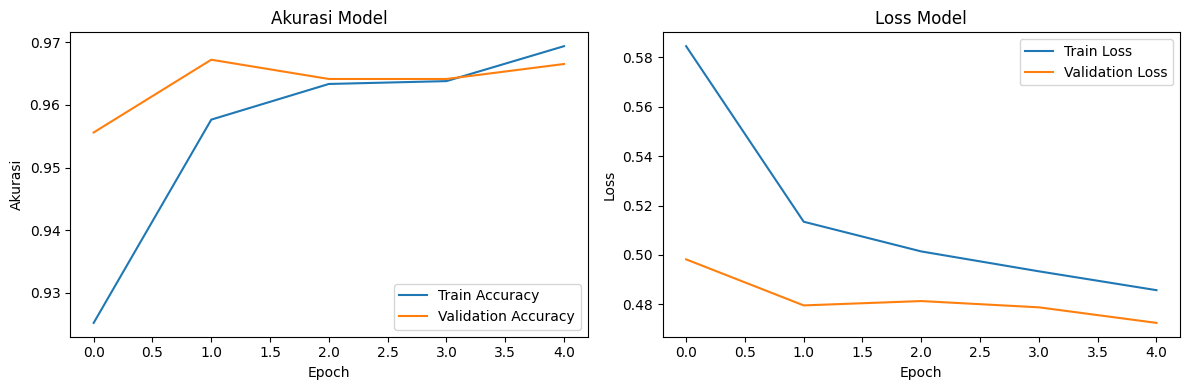

In [12]:
from tensorflow.keras.models import load_model
# Plot History
plt.figure(figsize=(12, 4))
# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
# Membuat objek untuk plotting
# Ambil label True dari test_gen
test_gen.reset() # Reset image generator dari test set
predictions = model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_gen.classes
class_indices = test_gen.class_indices
labels_map = dict((v, k) for k, v in class_indices.items())
predicted_labels = [labels_map[k] for k in predicted_classes]
true_labels = [labels_map[k] for k in true_classes]

92/92 [==============================] - 188s 2s/step


In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
predictions = model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_gen.classes
class_indices = test_gen.class_indices

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
# Evaluation Metric
results = model.evaluate(test_gen, verbose=1)

acc = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Test Loss {results[0]:.5f}")
print(f"Test Accuracy {results[1]:.5f}")
print("Accuracy :", acc)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)


92/92 [==============================] - 178s 2s/step - loss: 0.4741 - accuracy: 0.9696
Test Loss 0.47410
Test Accuracy 0.96962
Accuracy : 0.9696245733788396
Precision: 0.9702336636280993
Recall   : 0.9696245733788396
F1-score : 0.9696443848186218


In [15]:
predicted_labels = [labels_map[k] for k in predicted_classes]
true_labels = [labels_map[k] for k in true_classes]
print("\n--- Classification Report ---")
print(classification_report(true_labels, predicted_labels))


--- Classification Report ---
              precision    recall  f1-score   support

         cat       1.00      1.00      1.00       608
         dog       1.00      1.00      1.00       585
    elephant       0.94      0.94      0.94       599
       horse       0.98      0.93      0.95       551
        lion       0.93      0.98      0.95       587

    accuracy                           0.97      2930
   macro avg       0.97      0.97      0.97      2930
weighted avg       0.97      0.97      0.97      2930



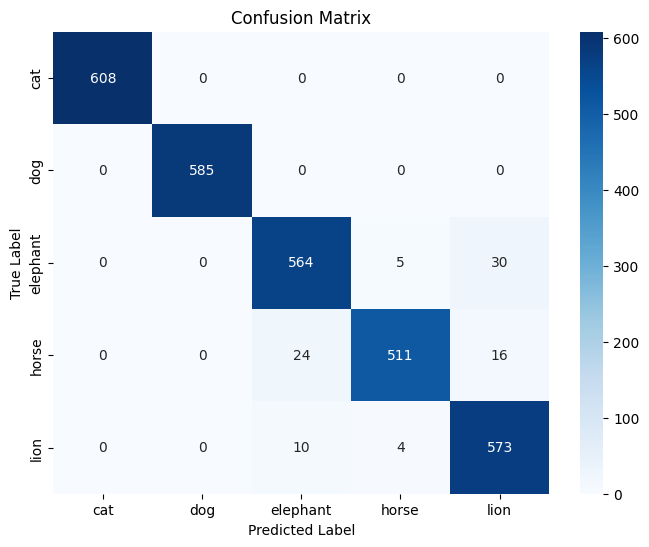

In [16]:
 # Heatmap Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_indices.keys(),
            yticklabels=class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [17]:
import pandas as pd
import time

def save_metrics_to_excel(filename, conv_name, history, test_loss, test_acc, acc, prec, rec, f1):
    data = {
        "Conv2D": [conv_name],
        "Train Acc": [history.history["accuracy"][-1]],
        "Train Loss": [history.history["loss"][-1]],
        "Val Acc": [history.history["val_accuracy"][-1]],
        "Val Loss": [history.history["val_loss"][-1]],
        "Test Acc": [test_acc],
        "Test Loss": [test_loss],
        "Accuracy": [acc],
        "Precision": [prec],
        "Recall": [rec],
        "F1-score": [f1],
    }

    df = pd.DataFrame(data)

    try:
        old = pd.read_excel(filename)
        df = pd.concat([old, df], ignore_index=True)
    except:
        pass

    df.to_excel(filename, index=False)


In [18]:
import re
import matplotlib.pyplot as plt

def safe_filename(name):
    return re.sub(r'[<>:"/\\|?*]', '_', name)

def save_plot(history, conv_name):
    safe_name = safe_filename(conv_name)

    plt.figure(figsize=(8,5))
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(conv_name)

    plt.savefig(f"plot_{safe_name}.png", dpi=300)
    plt.close()


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

def save_confusion_matrix(cm, class_indices, conv_name):
    safe_name = safe_filename(conv_name)

    labels = list(class_indices.keys())

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels,
                yticklabels=labels)

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(conv_name)

    plt.savefig(f"cm_{safe_name}.png", dpi=300)
    plt.close()


In [20]:
!pip install openpyxl


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
save_metrics_to_excel(
    "hasil_model.xlsx",
    "128->64",
    history,
    results[0],
    results[1],
    acc, precision, recall, f1
)

save_plot(history, "128->64")
save_confusion_matrix(cm, test_gen.class_indices, "128->64")



In [22]:
os.listdir()

['.ipynb_checkpoints',
 'BFDL1_Sultan_Hakim_Ramdhani.ipynb',
 'cm_128-_64.png',
 'hasil_model-plot_128-64.xlsx',
 'hasil_model.xlsx',
 'plot_128-_64.png']

In [24]:
# Convert to SavedModel
save_path = 'mymodel/'
tf.saved_model.save(model, save_path)

INFO:tensorflow:Assets written to: mymodel/assets


INFO:tensorflow:Assets written to: mymodel/assets


In [25]:
# Convert to HDF5 format
model.save('model.h5')

C:\Users\ASUS\tfenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
# Convert to tflite format
converter = tf.lite.TFLiteConverter.from_saved_model(save_path)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model_name.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
# Cell Inference